In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import utils

/home/t.desilva/.conda/envs/myEnv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device name:', torch.cuda.get_device_name(), '\n')

Device name: NVIDIA A100-SXM4-80GB 



In [3]:
traj = utils.read_traj(xtc_='../../Storage/Data/00.xtc', top_='../../Storage/Data/system.pdb')
# inp_traj = utils.minMaxScale(traj)
inp_traj = traj

batch_size = 256

traj_dl = DataLoader(inp_traj, batch_size=batch_size, shuffle=True, drop_last=True)
org_traj_dl = DataLoader(traj, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
# Used to check output image dimensions of each layer

conv1 = nn.ConvTranspose2d(256, 1024, kernel_size=(1,1))
input_ = torch.rand(16, 256, 127, 1)

print(conv1(input_).shape)

torch.Size([16, 1024, 127, 1])


In [5]:
class convVAE(nn.Module):
    def __init__(self, n_channels=4096, n_atoms = 127, latent_dim=16):
        super().__init__()
        
        self.n_channels = n_channels
        self.n_atoms = n_atoms
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            #(N,1,n_atoms,3)
            nn.Conv2d(1,n_channels,kernel_size=(1,1)), #(N,4096,127,3)
            nn.BatchNorm2d(n_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_channels,n_channels//4,kernel_size=(1,1)), #(N,1024,127,3)
            nn.BatchNorm2d(n_channels//4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_channels//4,n_channels//16,kernel_size=(1,3)), #(N,256,127,1)
            nn.BatchNorm2d(n_channels//16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_channels//16,latent_dim,kernel_size=(n_atoms,1)), #(N,latent_dim,1,1)
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            #(N,latent_dim,1,1)
            nn.ConvTranspose2d(latent_dim,n_channels//16,kernel_size=(127,1)), #(N,256,n_atoms,1)
            nn.BatchNorm2d(n_channels//16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_channels//16, n_channels//4, kernel_size=(1,1)), #(N,1024,127,1)
            nn.BatchNorm2d(n_channels//4),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_channels//4, n_channels, kernel_size=(1,1)), #(N,4096,127,1)
            nn.BatchNorm2d(n_channels),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(n_channels, 1, kernel_size=(1,3)), #(N, 1, n_atoms, 3)
            # nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # symmetric_output = (decoded + decoded.transpose(-1, -2)) / 2.0  # Calculate symmetric output
#         clamped_output = torch.clamp(symmetric_output, min=0, max=1.0)
        return decoded

In [6]:
model = convVAE(n_atoms=127).to(device)
# model.double()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

summary(model, input_size=(32, 1, 127, 3))

Layer (type:depth-idx)                   Output Shape              Param #
convVAE                                  [32, 1, 127, 3]           --
├─Sequential: 1-1                        [32, 16, 1, 1]            --
│    └─Conv2d: 2-1                       [32, 4096, 127, 3]        8,192
│    └─BatchNorm2d: 2-2                  [32, 4096, 127, 3]        8,192
│    └─LeakyReLU: 2-3                    [32, 4096, 127, 3]        --
│    └─Conv2d: 2-4                       [32, 1024, 127, 3]        4,195,328
│    └─BatchNorm2d: 2-5                  [32, 1024, 127, 3]        2,048
│    └─LeakyReLU: 2-6                    [32, 1024, 127, 3]        --
│    └─Conv2d: 2-7                       [32, 256, 127, 1]         786,688
│    └─BatchNorm2d: 2-8                  [32, 256, 127, 1]         512
│    └─LeakyReLU: 2-9                    [32, 256, 127, 1]         --
│    └─Conv2d: 2-10                      [32, 16, 1, 1]            520,208
│    └─ReLU: 2-11                        [32, 16, 1, 1]   

In [7]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_epochs = 100
outputs = []
for epoch in range(0,num_epochs+1):
    for batch, org_batch in zip(traj_dl,org_traj_dl):
        recon = model(batch.reshape(-1,1,127,3).to(device))
        loss = criterion(recon.to(device), org_batch.reshape(-1,1,127,3).to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        outputs.append(loss.item())
    if epoch%10==0:
        print(f'Epoch:{epoch:>3d}/{num_epochs} \t|\t Loss:{loss.item():.6f}')
#     outputs.append((epoch, dmat_org[0], recon))

Epoch:  0/100 	|	 Loss:25.425058
Epoch: 10/100 	|	 Loss:0.137462
Epoch: 20/100 	|	 Loss:0.070806
Epoch: 30/100 	|	 Loss:0.051211
Epoch: 40/100 	|	 Loss:0.042381
Epoch: 50/100 	|	 Loss:0.039077
Epoch: 60/100 	|	 Loss:0.036835
Epoch: 70/100 	|	 Loss:0.034073
Epoch: 80/100 	|	 Loss:0.031686
Epoch: 90/100 	|	 Loss:0.031993
Epoch:100/100 	|	 Loss:0.031082


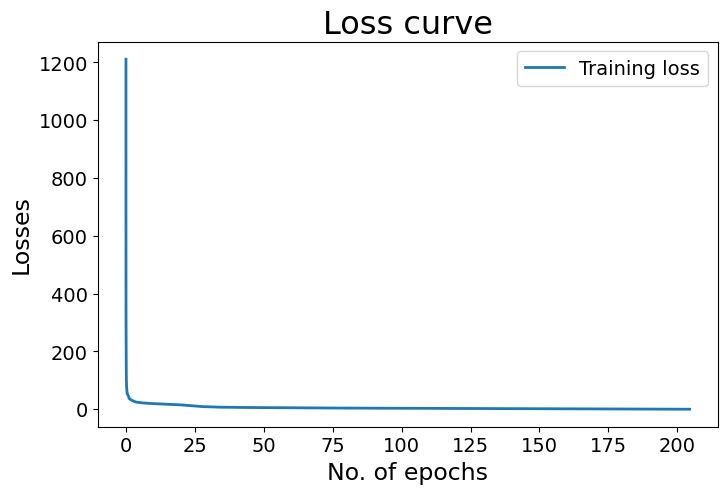

In [8]:
plt.figure(figsize=(8, 5))

plt.plot(outputs,range(len(outputs)), linewidth=2, label='Training loss')
# plt.plot(test_loss, 'c--', linewidth=2, label='Test loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=17)
plt.ylabel('Losses', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14);

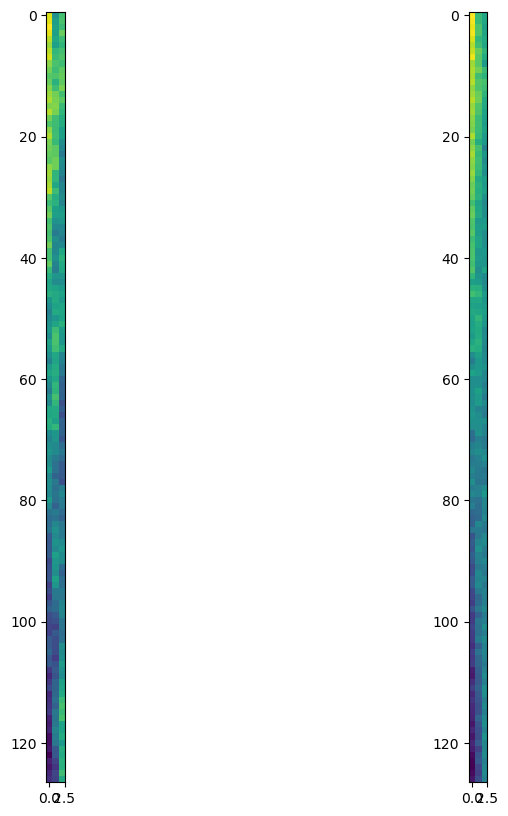

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10,10))
ax[0].imshow(traj[0].reshape(-1,3))
ax[1].imshow(model(torch.tensor(traj[0]).to(device).reshape(-1,1,127,3))[0].to('cpu').detach().numpy().reshape(-1,3))

In [10]:
traj[0][-1]

array([-0.72329926, -0.60518116,  0.18986614], dtype=float32)

In [11]:
model(torch.tensor(traj[0]).to(device).reshape(-1,1,127,3))[0].to('cpu').detach().numpy().reshape(-1,3)[-1]

array([-0.7945115 , -0.47141612, -0.11401653], dtype=float32)